# Implementando un Shallow Neuronal Network

En este notebook vamos a implementar un Shallow Neuronal Network, que tiene solo un hidden layer.
El problema que resolveremos sera el clasificacion de datos.
Por motivos de aprendizaje, no usaremos ningun Deep Learning framework, sino solamente numpy

**Vamos a aprender:**
- A implementar la arquitectura de un Deep Learning model con un solo hidden layer (Shallow Neuronal Network), que incluye:
    - Inicializacion de parametros
    - Forward Propagation
    - Cost calculation
    - Backward propagation usando el algoritmo de optimizacion Gradient Descent
    - Actualizaremos los parametros, para seguir dando pequenios pasos hacia la solucion final

## 1 - Settings iniciales
Antes de comenzar a implementar nuestro modelo, necesitamos importar las librerias que usaremos y preparar los datos con los que entrenaremos nuestro modelo.

### 1.1 - Importar las librarias que usaremos
El primer paso es importar los paquetes que utilizaremos
- [numpy](www.numpy.org) es un paquete fundamental en python para el computo de matrices
- [h5py](http://www.h5py.org) para leer con nuestros datos (imagenes) que estan en formato H5
- [matplotlib](http://matplotlib.org) libreria Python para generar graficos.
- [PIL](http://www.pythonware.com/products/pil/) y [scipy](https://www.scipy.org/) para probar al final nuestro modelo ya entrenado.

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
#from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
#from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

### 1.2 - Cargando nuestros datos
Definiremos un metodo que se encargara de cargar nuestros datos de entrenamiento y dividirlos en train_set (para entrenar) test_set para validar el performance de nuestro modelo despues de haberlo entranado

In [2]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

Validamos que nuestros datos se hayan cargado correctamente

In [3]:
X, Y = load_planar_dataset()

Ahora vizualizamos los datos, como se ve los datos tienen una forma de una flow y cada petalo es un color azul o rojo

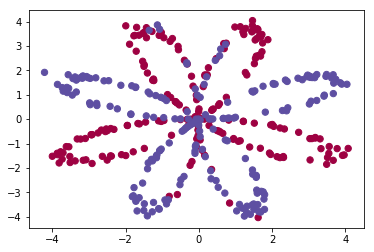

In [4]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Exploremos tambien las dimensciones de nuestros datasets

In [5]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


## 2 - Intentando con un Logistic Regression
Veamos si se puede resolver este problem con el simple Logistic Regression que implementamos antes. Usaremos la implementacion de Logistic Regression de la libreria sklearn (No preocuparse por el warning message)

In [6]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Necesitaremos un metodo de ayuda para visualizar el decision boundary

In [7]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

Vizualizamos ahora como este modelo resuelve este problema

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


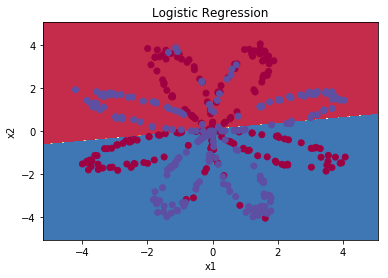

In [8]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

El conjunto de datos no es separable linealmente, por lo que un Logistic Regression no funciona bien. Esperemos que una red neuronal funcione mejor. Probemos esto ahora!

## 3 - Implementando nuestro modelo
Es tiempo de implementar nuestro modelo, un Shallow Neuronal Network que tiene solo un hidden layer.

Los pasos para construir un modelo Deep Learning son:
1. Definir la estructura del modelo, como el numero de inputs, numero de layers y neuronas. (En este caso un hidden layer y el ouput layer)
2. Definir Inicializar los parametros 
3. Ciclo de entrenamiento (Learning Loop):
    - 3.1) Forward propagation
    - 3.2) Calculate the cost
    - 3.3) Backward propagation (Calculate the current gradients)
    - 3.4) Update parameters (en base a los gradients)
    
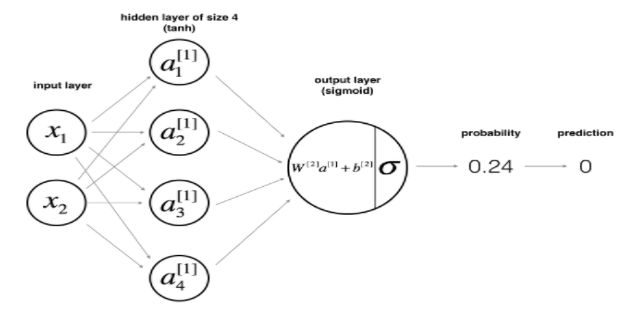

### 3.1 - Helper functions

Primero necesitamos implementar la funcion `sigmoid()`. que es la que utilizaremos como activacion funcion de nuestro ouput layer.

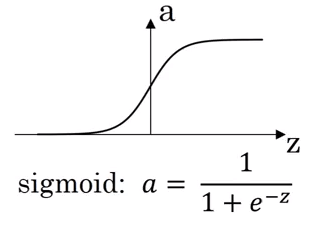

In [9]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

### 3.2 - Definición de la estructura de la red neuronal
Definimos en este metodo tres variables:
 - n_x: el tamaño de la capa de entrada
 - n_h: el tamaño de la capa oculta (Hardcoded 4) 
 - n_y: el tamaño de la capa de salida


In [10]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

### 3.3 - Inicializamos los parameters

El primer paso es inicializar los parametros W y b
W lo inicializaremos con valores random
b lo inicializaremos con ceros 0

In [11]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 3.4 - Implementando Forward propagation

Ahora implementamos el Forward propagation

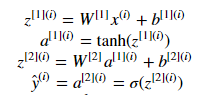

In [12]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = W1.dot(X) + b1
    A1 = np.tanh(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

### 3.5 - Implementando el Cost function

Ahora implementamos el calculo del cost function

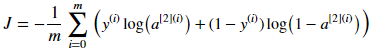

In [13]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = (np.multiply(np.log(A2),Y)) + (np.multiply((1 - Y), np.log(1 - A2)))
    cost = -1/m * np.sum(logprobs)
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

### 3.6 - Implementando Backward propagation

Ahora implementamos el Forward propagation

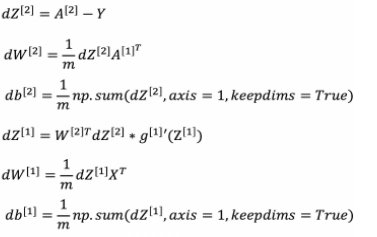

In [14]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims = True)
    dZ1 = W2.T.dot(dZ2) * (1 - np.power(A1, 2))
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims = True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

### 3.7 - Actualizando los parameters
Es momento de actualizar los parametros usando los gradients y dar otro pequenio paso hacer nuestra meta.

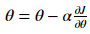

In [15]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

## 4 - Creando nuestro modelo usando las funciones anteriores

Finalmente estamos listos para entrenar nuestro modelo

In [16]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

Ahora vamos a implementar el metodo para predecir nuestro output

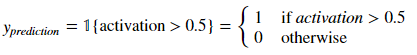

In [17]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

Ahora entrenamos nuestro modelo

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219504
Cost after iteration 9000: 0.218571


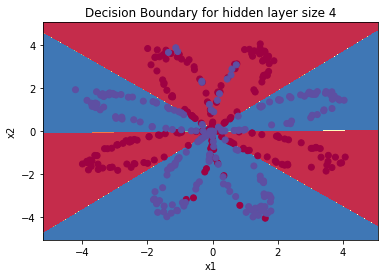

In [18]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Ahora veamos el performance de nuestro modelo

In [19]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


Finalmente, veamos que pasa si variamos el numero de neuronas en nuestro hidden layer

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.75 %


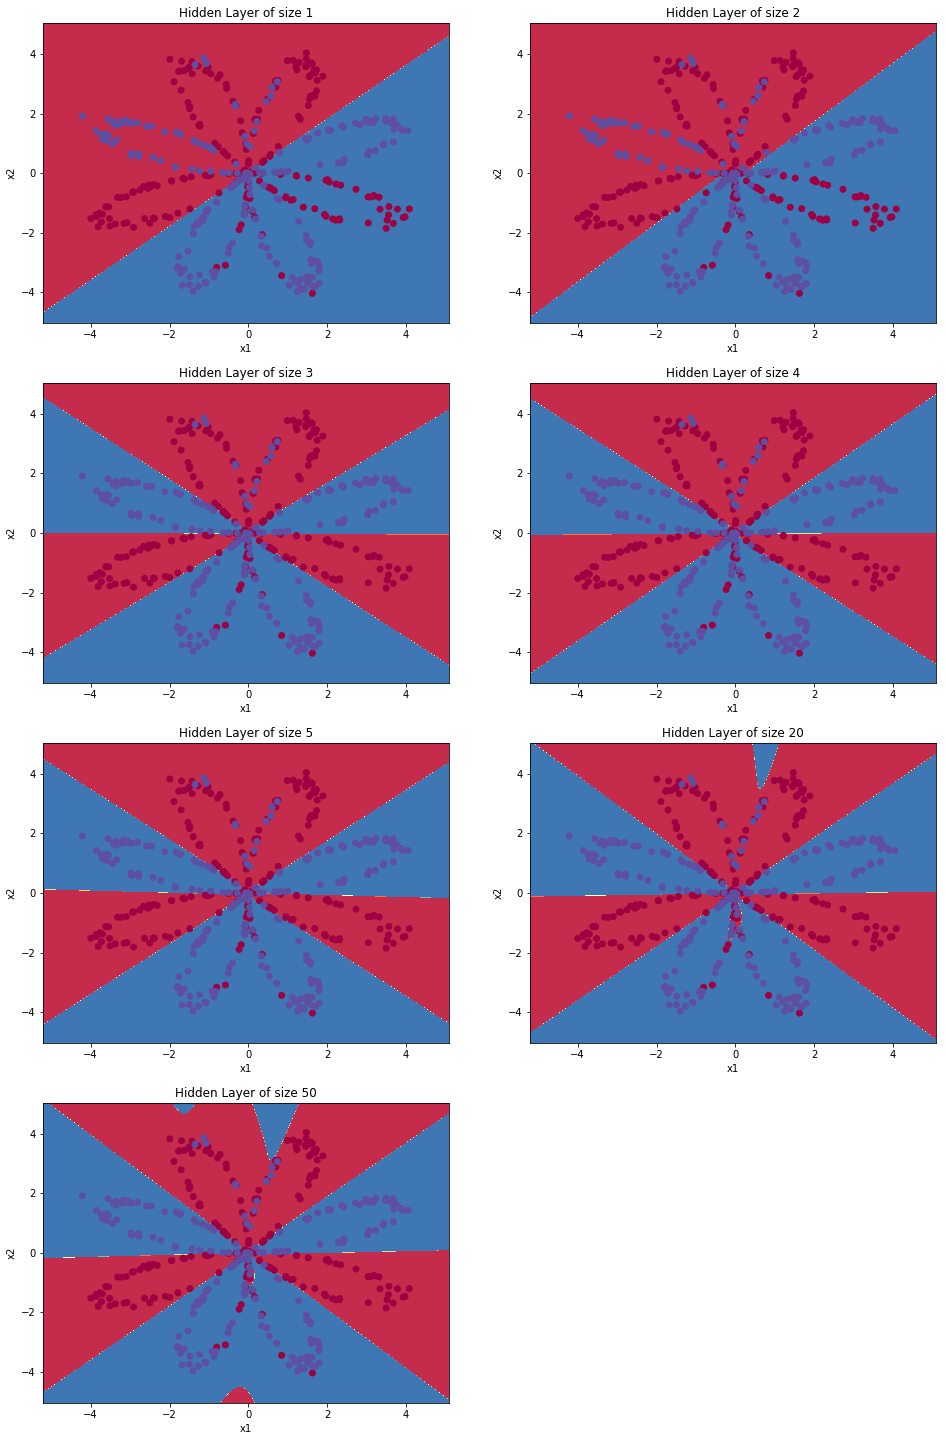

In [20]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))